# Project: Support Vector Machines (SVM)

## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as LOS.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test.csv*. Apply your final model to this extra dataset and submit to Kaggle competition to obtain accuracy of prediction (follow the requested format).

Try to optimize hyperparameters of your SVM model.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset.
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*.
6. Test the performance on the test file by submitting to Kaggle, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

For the in-class version, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ SVMs method(s) have been used - 25%
+ Probability of death for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Class imbalance management - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

In [1]:
import pandas as pd
# Training dataset
data=pd.read_csv('mimic_train.csv')
data.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [2]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('mimic_test_death.csv')
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


### Subsampling training data

For the **in-class** part of this project you are **recommended** to work with only a **subset of the observations** in the training data. This is because for a dataset of this size, SVM can be very very slow to fit.

The code below will do this for you

**Note I** you will still need a prediction for the whole testing set to get a score in Kaggle - for SVM it is training that is computationally expensive, producing predictions is (relatively) easy

**Note II**  for the extended project you should work with the full data

In [3]:
#your code here
from numpy import random

random.seed(10)## fixing the seed of your subsample

n_subset = 2000## size of the subsample
ind_subset = random.choice(data.shape[0], size= n_subset, replace=False)## indicies of your sampled points

data_subset = data.copy().iloc[ind_subset,]## selecting the subsampled indicies
data_subset.shape
data_subset.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
3246,0,66717,169165,268459,58.0,96.0,78.714286,84.0,140.0,115.400000,...,-44388.46186,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,4241,CSRU,1.0992
2250,0,91513,181783,295396,66.0,111.0,88.697674,118.0,208.0,152.279070,...,-61929.45537,EMERGENCY,Private,NOT SPECIFIED,SINGLE,WHITE,INTRACRANIAL HEMORRHAGE,431,SICU,16.5155
9678,0,65547,198397,247688,53.0,95.0,72.034483,75.0,150.0,121.655172,...,-60053.10961,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,PATIENT DECLINED TO ANSWER,STEMI,41011,CCU,1.8512
11780,0,28902,102777,202879,NaN,NaN,NaN,NaN,NaN,NaN,...,-64563.08174,EMERGENCY,Private,CATHOLIC,DIVORCED,WHITE,CHEST PAIN,41011,CCU,3.1251
9371,0,82023,181150,215930,71.0,88.0,78.666667,117.0,149.0,125.914286,...,-35719.13114,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,WHITE,LIVER FAILURE;HEPATITIS C,07044,SICU,10.0560


### DATA MANIPULATION BEFORE SMV

Note that I'm not using the created subset in this version, but if you do so, you can run the whole in just a few seconds.

In [4]:
#import auxiliar functions and packages
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
import scipy
from sklearnex import patch_sklearn
#patch_sklearn() #It helps to improve performace of intel processors
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

random.seed(546)

#create X and y test and y train

y_train = data['HOSPITAL_EXPIRE_FLAG']
X_train = data.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1).copy()
X_test = data_test.copy()

Now I transform DOB and ADMITTIME to get the age of each patient. This is an experiment I'm running for first time here, so it may be incorrect.

In [5]:
# dates transformation
from datetime import datetime, timedelta

# Define a function get the diffrence in days bewteen two dates:
def date_difference(date_str):
    date_obj1 = datetime.strptime(date_str['DOB'], '%Y-%m-%d %H:%M:%S')
    date_obj2 = datetime.strptime(date_str['ADMITTIME'], '%Y-%m-%d %H:%M:%S')
    delta = date_obj2 - date_obj1
    return (delta.days) / 365

X_train['age'] = X_train.apply(date_difference, axis=1)
X_test['age'] = X_test.apply(date_difference, axis=1)

In [6]:
#Check if ages are correct
above_80_count = (X_test.age > 100).sum()
print(above_80_count)

270


In [7]:
# We need to deal with outliers, so I set age values to a maximum of 100 (something in my transformation might be wrong)
X_train['age'] = X_train['age'].apply(lambda x: np.clip(x, None, 90))
X_test['age'] = X_test['age'].apply(lambda x: np.clip(x, None, 90))

I add numerical variables relevant to the analysis and also some categorical features. Moreover, id variables will be dropped:

In [8]:
#I create lists containing the variables I want to omit (including those that are not in the test set):
list_drop_train = ['subject_id','hadm_id','icustay_id','DOD','ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'LOS', 'Diff', 'DOB']

list_drop_test = ['subject_id','hadm_id','icustay_id','ADMITTIME', 'Diff', 'DOB']

#drop id variables andcategorical variables
X_train = X_train.drop(list_drop_train, axis=1)
X_test = X_test.drop(list_drop_test, axis=1)

# I create lists of numeric and categorical columns of the train set that will come in handy later on:
cnames_categorical=list(X_train.select_dtypes(include =['object']).columns)
print(cnames_categorical)

cnames_numeric=list(X_train.select_dtypes(exclude =['object']).columns)
print(cnames_numeric)

['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT']
['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'age']


#I'm checking how many unique values were generated
print(X_train['DIAGNOSIS'].unique())
print(X_test['DIAGNOSIS'].unique())

We want to check if there are missing values in our variables. If so, an imputation method will be required:

In [9]:
#Check for Nan
Nulls_train = X_train.isnull().sum()
Nulls_test = X_test.isnull().sum()

# We have to check both X_train and X_test

print(Nulls_train)
print(Nulls_test)

# Identifying Columns with Null variables
missing_data_col_X_train = X_train.columns[Nulls_train>0]
missing_data_col_X_test = X_test.columns[Nulls_test>0]
missing_data_col_X_train
missing_data_col_X_test

HeartRate_Min     2187
HeartRate_Max     2187
HeartRate_Mean    2187
SysBP_Min         2208
SysBP_Max         2208
SysBP_Mean        2208
DiasBP_Min        2209
DiasBP_Max        2209
DiasBP_Mean       2209
MeanBP_Min        2186
MeanBP_Max        2186
MeanBP_Mean       2186
RespRate_Min      2189
RespRate_Max      2189
RespRate_Mean     2189
TempC_Min         2497
TempC_Max         2497
TempC_Mean        2497
SpO2_Min          2203
SpO2_Max          2203
SpO2_Mean         2203
Glucose_Min        253
Glucose_Max        253
Glucose_Mean       253
GENDER               0
ADMISSION_TYPE       0
INSURANCE            0
RELIGION             0
MARITAL_STATUS     722
ETHNICITY            0
DIAGNOSIS            0
ICD9_diagnosis       0
FIRST_CAREUNIT       0
age                  0
dtype: int64
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'MARITAL_STATUS'],
      dtype='object')

Only marital status requires imputation, but I apply a general method for any:

# Create a subset of X_train and X_test with the specified columns
X_train_subset = X_train[cnames_categorical]
X_test_subset = X_test[cnames_categorical]

#Impute categorical variables
imp_frequent = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

imp_frequent.fit(X_train_subset) #use train median!

X_train_subset = pd.DataFrame(imp_frequent.transform(X_train_subset), columns = cnames_categorical)
X_test_subset = pd.DataFrame(imp_frequent.transform(X_test_subset), columns = cnames_categorical)

# Update the original DataFrames with the imputed values
X_train[cnames_categorical] = X_train_subset
X_test[cnames_categorical] = X_test_subset

#Check if imputation was done correctly
print(X_train.isnull().sum())
print(X_test.isnull().sum())

Target encoder from category_encoders used on categorical features. I ran out of time to try other encoders such as CatboostEncoder or experiment more with one-hot.

In [10]:
# Load the TargetEncoder  
from category_encoders import TargetEncoder

categorical_cols = cnames_categorical
Target = 'HOSPITAL_EXPIRE_FLAG'
for col in categorical_cols:
    te = TargetEncoder(handle_missing = 'return_nan')
    # fit the data
    te.fit(X = X_train[col], y = y_train)
    # transform
    values_train = te.transform(X_train[col])
    values_test = te.transform(X_test[col])
    X_train[col] = values_train
    X_test[col] = values_test

X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,GENDER,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0.115823,0.125554,0.134494,0.105340,0.081218,0.110177,0.071429,0.097436,0.139468,69.608219
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0.115823,0.125554,0.085989,0.190099,0.111755,0.110177,0.096354,0.097673,0.139468,42.101370
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0.115823,0.125554,0.134494,0.105340,0.108333,0.092059,0.089189,0.145399,0.139468,68.210959
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,0.115823,0.032654,0.134494,0.099296,0.137637,0.110177,0.093420,0.075025,0.116637,74.961644
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.115823,0.125554,0.134494,0.127174,0.137637,0.110177,0.146259,0.025200,0.106994,79.424658


In case a variable is not in the train and test set at the set time, we have to remove it:

In [11]:
#Get the common column names
common_columns = list(set(X_train.columns).intersection(X_test.columns))

#Create new dataframes with only the common columns
X_train = X_train[common_columns]
X_test = X_test[common_columns]

I'm going to try imputation by mean on both train-test sets instead of removing cols (numeric variables). I will try to impute numeric features through simple imputer with mean function from sklearn:

In [12]:
#KNN imputation

from sklearn.impute import KNNImputer

imp_knn = KNNImputer(n_neighbors= 5, weights = 'distance')

imp_knn.fit(X_train) #use train values!

X_train = pd.DataFrame(imp_knn.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imp_knn.transform(X_test), columns = X_test.columns)

#Check if imputation was done correctly
print(X_train.isnull().sum())
print(X_test.isnull().sum())

RespRate_Mean     0
SysBP_Max         0
Glucose_Max       0
Glucose_Min       0
DiasBP_Min        0
HeartRate_Mean    0
RespRate_Max      0
MARITAL_STATUS    0
DIAGNOSIS         0
HeartRate_Min     0
SysBP_Min         0
ETHNICITY         0
SpO2_Mean         0
SpO2_Min          0
SpO2_Max          0
Glucose_Mean      0
ADMISSION_TYPE    0
HeartRate_Max     0
MeanBP_Max        0
ICD9_diagnosis    0
GENDER            0
RespRate_Min      0
DiasBP_Max        0
MeanBP_Mean       0
TempC_Max         0
INSURANCE         0
RELIGION          0
MeanBP_Min        0
TempC_Min         0
TempC_Mean        0
age               0
DiasBP_Mean       0
FIRST_CAREUNIT    0
SysBP_Mean        0
dtype: int64
RespRate_Mean     0
SysBP_Max         0
Glucose_Max       0
Glucose_Min       0
DiasBP_Min        0
HeartRate_Mean    0
RespRate_Max      0
MARITAL_STATUS    0
DIAGNOSIS         0
HeartRate_Min     0
SysBP_Min         0
ETHNICITY         0
SpO2_Mean         0
SpO2_Min          0
SpO2_Max          0
Glucose

In [ ]:
#IMBALANCES 
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(
    n_estimators=100, random_state=0, sampling_strategy="all", replacement=True
)
brf.fit(X_train, y_train)
y_train = brf.predict(X_train)
#balanced_accuracy_score(y_test, y_pred)


Finally, we must scale data before fitting the model and producing predicted probabilities:

In [13]:
#Data scaling
scaler = preprocessing.StandardScaler(with_mean = True, with_std = True)
scaler.fit(X_train) ## fit it to the train set
#Scale both sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#View data
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)

### SVM model

First, we find the optimal parameters thorugh Gridsearch using score = Accuracy (not auc in this case) with probability = False to reduce computational cost. Once we have found the optimal values of gamma and C, we use them to fit a normal SVC model with probability = True. THis way, we will be able to produce 

In [14]:
#SVM model

##JUST FOR THE IN-CLASS TEST. IN ANY OTHER SITUATION Probability = True for grid search!
my_SVM_model = SVC(probability = True)

grid_values = {'gamma':[0.25, 0.5, 1, 'C':[0.1, 0.25, 0.75], 'kernel':['linear', 'rbf']}

grid_svc_acc = GridSearchCV(my_SVM_model, param_grid = grid_values,scoring = 'roc_auc', n_jobs = -1, cv = 5)

#Fit the model
grid_svc_acc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 0.25, 0.75, 1],
                         'gamma': [0.25, 0.5, 1, 1.5],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')

best parameters: {'C': 0.1, 'gamma': 0.25, 'kernel': 'linear'}
best score:      0.88660 (+/-0.00785)


,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,0.25,linear,"{'C': 0.1, 'gamma': 0.25, 'kernel': 'linear'}",0.888522,0.875710,0.879758,0.897208,0.891781,0.886596,0.007855,1
2,0.1,0.5,linear,"{'C': 0.1, 'gamma': 0.5, 'kernel': 'linear'}",0.888522,0.875710,0.879758,0.897208,0.891781,0.886596,0.007855,1
4,0.1,1,linear,"{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",0.888522,0.875710,0.879758,0.897208,0.891781,0.886596,0.007855,1
6,0.1,1.5,linear,"{'C': 0.1, 'gamma': 1.5, 'kernel': 'linear'}",0.888522,0.875710,0.879758,0.897208,0.891781,0.886596,0.007855,1
30,1,1.5,linear,"{'C': 1, 'gamma': 1.5, 'kernel': 'linear'}",0.888651,0.875573,0.879762,0.897269,0.891599,0.886571,0.007892,5
26,1,0.5,linear,"{'C': 1, 'gamma': 0.5, 'kernel': 'linear'}",0.888651,0.875573,0.879762,0.897269,0.891599,0.886571,0.007892,5
24,1,0.25,linear,"{'C': 1, 'gamma': 0.25, 'kernel': 'linear'}",0.888651,0.875573,0.879762,0.897269,0.891599,0.886571,0.007892,5
28,1,1,linear,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.888651,0.875573,0.879762,0.897269,0.891599,0.886571,0.007892,5
14,0.25,1.5,linear,"{'C': 0.25, 'gamma': 1.5, 'kernel': 'linear'}",0.888534,0.875613,0.879766,0.897212,0.891707,0.886566,0.007872,9
12,0.25,1,linear,"{'C': 0.25, 'gamma': 1, 'kernel': 'linear'}",0.888534,0.875613,0.879766,0.897212,0.891707,0.886566,0.007872,9


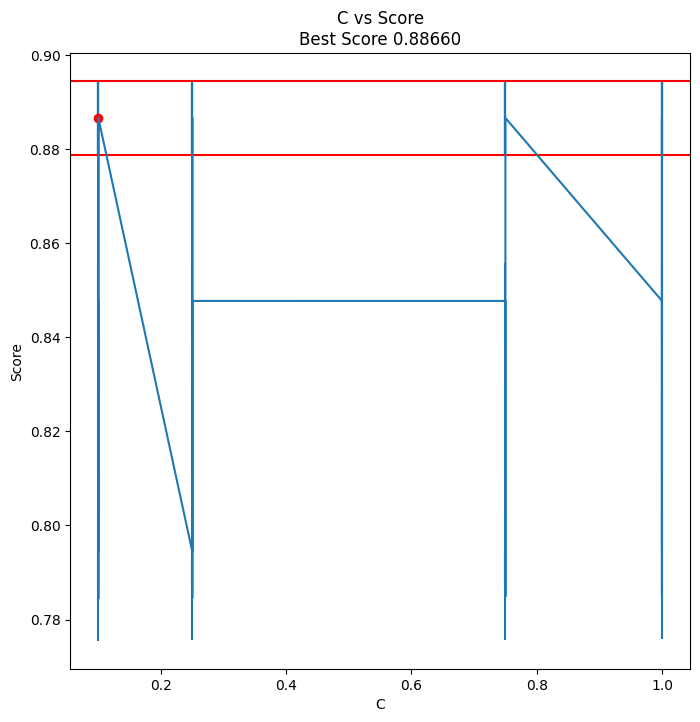

In [15]:
#what is the best model?
GridSearch_table_plot(grid_svc_acc, "C", negative = False, display_all_params = False) #C = 1, gamma = 0.25 for my gridsearch with accuracy

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

## In-sample predicted probabilities and In-sample predicted scores 

#insample_prob_pred = MySvc.predict_proba(X_train)
insample_prob_pred = grid_svc_acc.predict_proba(X_train)

# auc score (using predic_proba from MySvc)
print(roc_auc_score(y_train, insample_prob_pred[:,1]))

0.8883411881875873


In [18]:
#Predicted probabilities using test variables

y_pred_proba = grid_svc_acc.predict_proba(X_test)

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [19]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_pred_proba[:,1]})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)